Treinando um Classificador
=====================

Geralmente, ao lidar com imagens, textos, áudios ou vídeos, você pode usar bibliotecas padrão do Python que carregam os dados em arrays do NumPy.
Depois, você pode converter esse array em um torch.*Tensor.

Para imagens, bibliotecas como Pillow e OpenCV são úteis.

Para áudio, bibliotecas como scipy e librosa.

Para texto, pode-se usar carregamento direto com Python ou Cython, ou bibliotecas como NLTK e SpaCy.

Especificamente para visão computacional, existe o pacote torchvision, que contém carregadores de dados para conjuntos como ImageNet, CIFAR10, MNIST, etc., além de transformadores de dados como torchvision.datasets e torch.utils.data.DataLoader.

Isso facilita bastante e evita código repetitivo.

Neste tutorial, usaremos o conjunto de dados CIFAR10, com as classes:
‘avião’, ‘automóvel’, ‘pássaro’, ‘gato’, ‘veado’, ‘cachorro’, ‘sapo’, ‘cavalo’, ‘navio’, ‘caminhão’.
As imagens são coloridas (3 canais) de 32x32 pixels.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Treinando um classificador de imagens
----------------------------

Vamos seguir os seguintes passos:

1. Carregar e normalizar os dados de treino e teste do CIFAR10 usando `torchvision`
2. Definir uma Rede Neural Convolucional
3. Definir uma função de perda
4. Treinar a rede com os dados de treino
5. Testar a rede com os dados de teste

### 1. Carregando e normalizando CIFAR10

Usando `torchvision`, é fácil carregar a CIFAR10.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

A saída dos datasets do torchvision são imagens PILImage no intervalo \[0,
1\]. Nós as transformamos em tensores com intervalo normalizado \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Se estiver rodando no Windows e receber um erro BrokenPipeError, tente configurar o parâmetro num_workers de torch.utils.data.DataLoader() para 0.</p>

</div>



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Vamos exibir algumas imagens de treino, por diversão.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

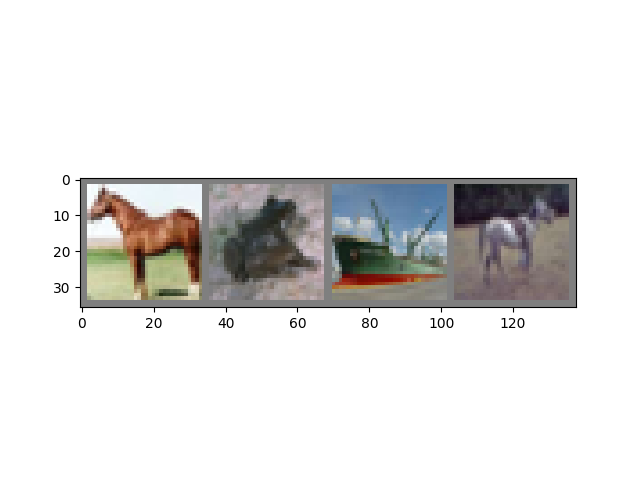

Out: horse frog  ship  horse

## 2. Definindo uma Rede Neural Convolucional


A rede neural abaixo é copiada de outro tutorial da Pytorch (sobre Redes Neurais)  e modificada para aceitar imagens com 3 canais (em vez de 1 canal).


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Definindo Função de Perda e Otimizador


Vamos usar a função de perda de Entropia Cruzada para Classificação e o otimizador SGD com momentum.


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Treinando a Rede


Aqui as coisas começam a ficar interessantes.
Vamos iterar sobre os dados, alimentar a rede e otimizá-la.


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Vamos salvar rapidamente o modelo treinado:


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Veja [aqui](https://pytorch.org/docs/stable/notes/serialization.html) para mais detalhes sobre como salvar modelos no PyTorch.

## 5. Testando a Rede nos Dados de Teste


Treinamos a rede por 2 épocas com o conjunto de dados de treinamento.
Mas precisamos verificar se a rede realmente aprendeu algo.

Vamos fazer isso prevendo os rótulos e comparando com os rótulos reais.
Se a predição estiver correta, consideramos como acerto.

Primeiro passo: mostrar uma imagem do conjunto de teste para nos familiarizarmos.


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

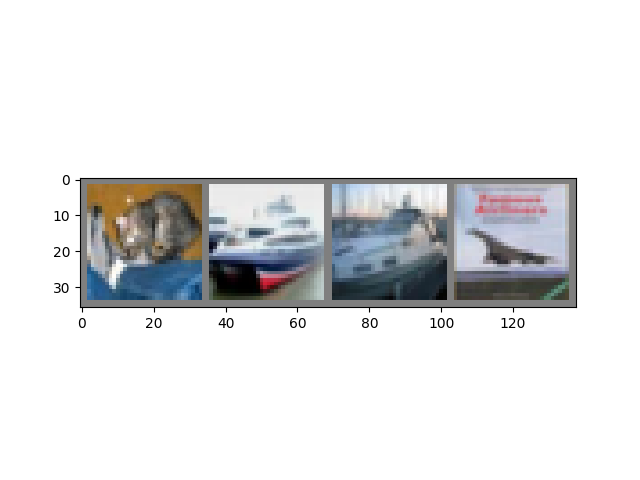

Agora, vamos carregar o modelo salvo (não era necessário, mas serve como ilustração).


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

Vamos ver o que a rede acha dos exemplos mostrados acima:


In [ ]:
outputs = net(images)

As saídas são valores de energia para as 10 classes.

Quanto maior a energia, mais a rede acredita que a imagem pertence àquela classe.
Vamos pegar o índice com a maior energia:


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Os resultados parecem bem bons.

Vamos ver como a rede se comporta com o conjunto completo de teste.


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Isso é bem melhor do que o acaso (10% de acerto aleatório).
Parece que a rede realmente aprendeu algo.

Hmmm... Quais classes foram bem e quais não foram?


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

E agora?

Como podemos rodar essas redes na GPU?

## Treinamento na GPU

Assim como transferimos um Tensor para a GPU, também transferimos a rede para ela.

Vamos definir o dispositivo como o primeiro CUDA visível, se estiver disponível:


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

O restante desta seção assume que `device` é um dispositivo CUDA.

Esses métodos convertem recursivamente todos os módulos, parâmetros e buffers para CUDA:

``` {.python}
net.to(device)
```

Lembre-se também de transferir as entradas e os rótulos para a GPU:

``` {.python}
inputs, labels = data[0].to(device), data[1].to(device)
```

#### Por que não percebo uma aceleração gigantesca comparado ao CPU?

- Porque sua rede é muito pequena.

**Exercício:** Tente aumentar a largura da sua rede (segundo argumento do primeiro `nn.Conv2d` e primeiro argumento do segundo `nn.Conv2d` — devem ser iguais) e veja qual aceleração é alcançada.


#### Outros tutoriais:


-   [Train neural nets to play video games](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)
-   [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
-   [Chat with other users on
    Slack](https://pytorch.slack.com/messages/beginner/)
